<a href="https://colab.research.google.com/github/Jang-KyungWuk/KR_Community_Word_Cloud_Generator/blob/master/Keyword%20Analyzer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
version=2.2
'''
<current version 2.2>
Added new algorithm 
  - recover_known_Keyword_wordcloud() : draw wordloud with only given keywords
Fixed article crawl on dcinside.com
'''

'\n<current version 2.1>\n~1.9 version algorithm available again.\n(add _v1dx to function name)\n\n<future version 2.2 will try>\nHyperlink based redundant-safe title crawl\nAdd word2vec or LDA feature (can be postponded. needs futher study)\n'

In [ ]:
def setup():
  '''
  FOR GOOGLE COLAB USERS START setup() 
  AND RESTART RUNTIME (CTRL+M) 
  THEN START setup() TO CHECK WHETHER KR FONT IS PRINTED CORRECTLY
  '''
  
  # Mount Google Drive
  from google.colab import drive
  drive.mount('/content/gdrive')
  base_dir="/content/gdrive/My Drive/"

  # KoNLPy Install
  !apt-get update
  !apt-get install g++ openjdk-8-jdk 
  !pip3 install konlpy==0.5.1

  # Install KR Font
  !apt -qq -y install fonts-nanum
  fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
  KR_Font_initializer(fontpath)

  # Install emoji to delete emojis
  !pip install emoji

  return base_dir

def KR_Font_initializer(fontpath):
  # For draw legend
  import matplotlib.pyplot as plt
  import matplotlib as mpl
  import matplotlib.font_manager as fm

  # Set KR Font for matplotlib
  font=fm.FontProperties(fname=fontpath,size=20)
  plt.rc('font',family='NanumBarunGothic')
  mpl.font_manager._rebuild()

  plt.bar(['KR font','성공'],[1,2])
  plt.show()

In [ ]:
def get_current_time_code():
  '''time_code()
  Generate time code from current time
  '''

  # Get current time (KST = GMT +9)
  KST=datetime.timezone(datetime.timedelta(hours=9))
  now=datetime.datetime.now(KST)
  YY=str(now.year)[2:4]
  MM=str(now.month)
  DD=str(now.day)

  hh=str(now.hour)
  mm=str(now.minute)
  ss=str(now.second)
  
  c_time=[YY,MM,DD,hh,mm,ss]
  for cursor in range (len(c_time)):
    if len(c_time[cursor])==1:
      c_time[cursor]="0"+c_time[cursor]
  time_code=''.join(c_time[0:3])+' '+'-'.join(c_time[3:6])

  return time_code

In [ ]:
# Function for coloring
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
  return tuple(Dark2_8.colors[random.randint(0,7)])

In [ ]:
# Function to find titles at DCinside
def dc_title_finder(tag):
  return tag.has_attr('href') and not tag.has_attr('class') and not tag.has_attr('rel')

In [ ]:
def keywords_filter(tags,keywords):
  filtered_tags=[]
  for tag in tags:
    if any(keyword in tag.text for keyword in keywords)==True:
      filtered_tags.append(tag)
  return filtered_tags

In [ ]:
def dcinside_crawl(pages,txt_files,crawl_title,crawl_article,
                   is_m_gallery,board_id,
                   request_delay,retry_delay,
                   dc_title_tag_pos, dc_official_announce,
                   user_agent,
                   base_dir,
                   filter=False,
                   keywords=[]):

  main_url="https://gall.dcinside.com"
  base_url=main_url*1
  if is_m_gallery==True:
    base_url+="/mgallery"
  base_url+=(("/board/lists/?id=%s&page=")%board_id)

  title_tag_pos_min, title_tag_pos_max=dc_title_tag_pos[0]+dc_official_announce, dc_title_tag_pos[1]+dc_official_announce

  for crawl_sector_cursor in range (len(pages)):
    crawl_min,crawl_max=pages[crawl_sector_cursor]

    if crawl_title==True:
      title_crawl_txt=open(base_dir + txt_files[0][crawl_sector_cursor],'w')
      
    if crawl_article==True:
      link_crawl_txt=open(base_dir + txt_files[1][crawl_sector_cursor],'w')


    for page in range (crawl_min,crawl_max):
      url=base_url+str(page)

      try:
        html=rq.get(url, headers={'User-Agent': user_agent}).text
      except (ProtocolError, ConnectionError, RemoteDisconnected) as error:
        print("Requesting page %s once more"%(page))
        time.sleep(retry_delay)
        try:
          html=rq.get(url, headers={'User-Agent': user_agent}).text
        except (ProtocolError, ConnectionError, RemoteDisconnected) as error:
          print("Canceled requesting page %s"%(page))
      
      soup=BeautifulSoup(html,'lxml')
      tags=soup.find_all(dc_title_finder)
      bbs_tags=tags[title_tag_pos_min:title_tag_pos_max]
      
      if filter==True:
        bbs_tags=keywords_filter(bbs_tags,keywords)

      for t in bbs_tags:
        if crawl_title==True:
          title_crawl_txt.write(t.text+'\n')
        if crawl_article==True:
          link_crawl_txt.write(main_url+t['href']+'\n')
      time.sleep(request_delay)

    if crawl_title==True:
      title_crawl_txt.close()

    if crawl_article==True:
      link_crawl_txt.close()

  if crawl_article==True:
    for crawl_sector_cursor in range (len(pages)):
      dirs=np.loadtxt(base_dir+txt_files[1][crawl_sector_cursor],delimiter="\n", dtype="str")
      article_crawl_txt=open(base_dir+txt_files[2][crawl_sector_cursor],'w')
      for dir in dirs:
        
        try:
          html=rq.get(dir, headers={'User-Agent':user_agent}).text
        except (ProtocolError, ConnectionError, RemoteDisconnected) as error:
          print("Requesting page %s once more"%(dir))
          time.sleep(retry_delay)
          try:
            html=rq.get(dir, headers={'User-Agent':user_agent}).text
          except (ProtocolError, ConnectionError, RemoteDisconnected) as error:
            print("Canceled requesting page %s"%(dir))
        
        soup=BeautifulSoup(html,'lxml')
        article=soup.body.find('div',{'class':'writing_view_box'}).text
        article=article.replace('\n',' ').replace('\u200b',' ').replace('\xa0','').replace('- dc official App','')
        article_crawl_txt.write(article+'\n')
        time.sleep(request_delay)
      
      article_crawl_txt.close()

In [ ]:
def ruliweb_crawl(pages,txt_files,crawl_title,crawl_article,board_id,ruliweb_bbs_articles,request_delay,retry_delay,
                  user_agent,base_dir,
                  filter=False, keywords=[]):
  
  main_url="https://bbs.ruliweb.com/community/board"
  base_url=main_url*1
  base_url+=(("/%s?page=")%board_id)

  for crawl_sector_cursor in range (len(pages)):
    crawl_min,crawl_max=pages[crawl_sector_cursor]

    if crawl_title==True:
      title_crawl_txt=open(base_dir + txt_files[0][crawl_sector_cursor],'w')
      
    if crawl_article==True:
      link_crawl_txt=open(base_dir + txt_files[1][crawl_sector_cursor],'w')


    for page in range (crawl_min,crawl_max):
      url=base_url+str(page)
      
      try:
        html=rq.get(url, headers={'User-Agent': user_agent}).text
      except (ProtocolError, ConnectionError, RemoteDisconnected) as error:
        print("Requesting page %s once more"%(page))
        time.sleep(retry_delay)
        try:
          html=rq.get(url, headers={'User-Agent': user_agent}).text
        except (ProtocolError, ConnectionError, RemoteDisconnected) as error:
          print("Canceled requesting page %s"%(page))
          break
      
      soup=BeautifulSoup(html,'lxml')
      title_soup=soup.find_all(lambda tag:tag.name=='a' and tag.get('class')==['deco'])
      title_tags=title_soup[len(title_soup)-ruliweb_bbs_articles:]

      if filter==True:
        title_tags=keywords_filter(title_tags,keywords)

      for t in title_tags:
        if crawl_title==True:
          title_crawl_txt.write(t.text+'\n')
        if crawl_article==True:
          link_crawl_txt.write(t['href']+'\n')
      time.sleep(request_delay)

    if crawl_title==True:
      title_crawl_txt.close()

    if crawl_article==True:
      link_crawl_txt.close()

  if crawl_article==True:
    for crawl_sector_cursor in range (len(pages)):
      dirs=np.loadtxt(base_dir+txt_files[1][crawl_sector_cursor],delimiter="\n", dtype="str")
      article_crawl_txt=open(base_dir+txt_files[2][crawl_sector_cursor],'w')
      for dir in dirs:

        try:
          html=rq.get(dir, headers={'User-Agent':user_agent}).text
        except (ProtocolError, ConnectionError, RemoteDisconnected) as error:
          print("Requesting page %s once more"%(dir))
          time.sleep(retry_delay)
          try:
            html=rq.get(dir, headers={'User-Agent':user_agent}).text
          except (ProtocolError, ConnectionError, RemoteDisconnected) as error:
            print("Canceled requesting page %s"%(dir))
            break
          
        soup=BeautifulSoup(html,'lxml')
        article_tags=soup.find_all("div",class_="view_content")
        article_text=''
        for article_tag in article_tags:
          article_text+=(article_tag.text+' ')
        article_text=article_text.replace('\u200b',' ')
        article_crawl_txt.write(article_text+'\n')
        
        time.sleep(request_delay)
      
      article_crawl_txt.close()

In [ ]:
def arca_crawl(pages,txt_files,crawl_title,crawl_article,board_id,
               request_delay,retry_delay,
               user_agent,
               base_dir,
               filter=False,
               keywords=[]):

  main_url="https://arca.live"
  base_url=main_url*1
  base_url+=(("/b/%s?p=")%board_id)

  for crawl_sector_cursor in range (len(pages)):
    crawl_min,crawl_max=pages[crawl_sector_cursor]

    if crawl_title==True:
      title_crawl_txt=open(base_dir + txt_files[0][crawl_sector_cursor],'w')
      
    if crawl_article==True:
      link_crawl_txt=open(base_dir + txt_files[1][crawl_sector_cursor],'w')

    for page in range (crawl_min,crawl_max):
      url=base_url+str(page)

      try:
        html=rq.get(url, headers={'User-Agent': user_agent}).text
      except (ProtocolError, ConnectionError, RemoteDisconnected) as error:
        print("Requesting page %s once more"%(page))
        time.sleep(retry_delay)
        try:
          html=rq.get(url, headers={'User-Agent': user_agent}).text
        except (ProtocolError, ConnectionError, RemoteDisconnected) as error:
          print("Canceled requesting page %s"%(page))
          break

      soup=BeautifulSoup(html,'lxml')

      title_tags=soup.find_all(attrs={'class':"title"})
      if crawl_article==True:
        link_tags=soup.find_all(lambda tag: tag.name == 'a' and tag.get('class') == ['vrow'])
      
      if filter==True:
        title_tags=keywords_filter(title_tags,keywords)

      for cursor in range (len(title_tags)):
        if crawl_title==True:
          title_crawl_txt.write(title_tags[cursor].text+'\n')
        if crawl_article==True:
          link_crawl_txt.write(main_url+link_tags[cursor]['href']+'\n')
      time.sleep(request_delay)

    if crawl_title==True:
      title_crawl_txt.close()

    if crawl_article==True:
      link_crawl_txt.close()

  if crawl_article==True:
    for crawl_sector_cursor in range (len(pages)):
      dirs=np.loadtxt(base_dir+txt_files[1][crawl_sector_cursor],delimiter="\n", dtype="str")
      article_crawl_txt=open(base_dir+txt_files[2][crawl_sector_cursor],'w')
      for dir in dirs:

        try:
          html=rq.get(dir, headers={'User-Agent':user_agent}).text
        except (ProtocolError, ConnectionError, RemoteDisconnected) as error:
          print("Requesting page %s once more"%(dir))
          time.sleep(retry_delay)
          try:
            html=rq.get(dir, headers={'User-Agent':user_agent}).text
          except (ProtocolError, ConnectionError, RemoteDisconnected) as error:
            print("Canceled requesting page %s"%(dir))
            break
            
        soup=BeautifulSoup(html,'lxml')
        article_tags=soup.find_all(attrs={'class':"fr-view article-content"})
        article_soup=BeautifulSoup(str(article_tags[0]),'lxml')
        articles_in_tag=article_soup.find_all('p')
        
        article=""
        for article_in_tag in articles_in_tag:
          article+=article_in_tag.text

        article=article.replace('\n',' ').replace('\u200b',' ').replace('\xa0','')
        article_crawl_txt.write(article+'\n')
        time.sleep(request_delay)
      article_crawl_txt.close()

In [ ]:
def name_txt_files(site,board_id,pages,time_code, crawl_title, crawl_article):
  txt_files=[[],[],[]] #Title, link, article

  if crawl_title==True:
    for crawl_page in pages:
      crawl_min,crawl_max=crawl_page
      txt_files[0].append(("%s %s %s title crawl %s~%s.txt")%(time_code, site, board_id, crawl_min, crawl_max-1))

  if crawl_article==True:
    for crawl_page in pages:
      crawl_min,crawl_max=crawl_page
      txt_files[1].append(("%s %s %s link crawl %s~%s.txt")%(time_code,site, board_id, crawl_min, crawl_max-1))
      txt_files[2].append(("%s %s %s article crawl %s~%s.txt")%(time_code, site, board_id, crawl_min, crawl_max-1))
  
  return txt_files

In [ ]:
def wordseed_reader(file_names,crawl_title,crawl_article,base_dir,pages,ignore_phrases):
  wordseeds=[]
  len_pages=len(pages)

  for crawl_sector_cursor in range (len_pages):
    wordseed=""
    if crawl_title==True:
        title_crawl_txt=open(base_dir+file_names[0][crawl_sector_cursor])
        wordseed+=title_crawl_txt.read()
        title_crawl_txt.close()

    if crawl_article==True:
        article_crawl_txt=open(base_dir+file_names[2][crawl_sector_cursor])
        wordseed+=article_crawl_txt.read()
        article_crawl_txt.close()
    wordseed=blank_emoji_deleter(wordseed)
    if len(ignore_phrases)!=0:
      wordseed=ignore_phrase(wordseed, ignore_phrases)
    wordseeds.append(wordseed)

  return wordseeds

In [ ]:
def blank_emoji_deleter(wordseed):
  # Delete '\n (Enter key input)'
  wordseed=wordseed.replace('\s+',' ').replace('\n',' ').replace('\u3000',' ')

  # Delete Emoji
  wordseed=emoji.get_emoji_regexp().sub(u'',wordseed)

  return wordseed

In [ ]:
def ignore_phrase(wordseed, phrases):
  for phrase in phrases:
    wordseed=wordseed.replace(phrase,'')
  return wordseed

In [ ]:
def morpheme_analysis(wordseed,user_dic,base_dir):
  if len(user_dic)==0:
    tagged_words=konlpy.tag.Komoran().pos(wordseed)
  else:
    tagged_words=konlpy.tag.Komoran(userdic=base_dir+user_dic).pos(wordseed)
  grammar="""
NP: {<N.*>*<Suffix>?}   # Noun phrase
VP: {<V.*>*}            # Verb phrase
AP: {<A.*>*}            # Adjective phrase
"""
  parser=nltk.RegexpParser(grammar)

  return tagged_words

In [ ]:
def morpheme_tag_filtter(tagged_words,selected_tags):
  filtered_word_seed=""
  for morpheme in tagged_words:
    if morpheme[1] in selected_tags:
      filtered_word_seed+=("%s "%morpheme[0]) 
  return filtered_word_seed

In [ ]:
def keyword_ranking(wordseed,show_rank,board_id,time_code,crawl_page,base_dir,site,show_ranking):

  crawl_min, crawl_max=crawl_page

  wordseed_list=wordseed.split()
  keywords=[]
  counts=[]

  for keyword in wordseed_list:
    if keyword in keywords:
      counts[keywords.index(keyword)]+=1
    else:
      keywords.append(keyword)
      counts.append(1)

  kwd_dict=dict(zip(keywords,counts))

  if show_ranking==True:
    plt_kw=[]
    plt_ct=[]
    for rank_cursor in range (show_rank):
      index=counts.index(max(counts))
      plt_kw.append(keywords.pop(index))
      plt_ct.append(counts.pop(index))
    plt_kw.reverse()
    plt_ct.reverse()
    plt.barh(plt_kw,plt_ct)
    plt.title("상위 %s개 키워드 등장 횟수"%(show_rank))
    plt.xlabel("등장 횟수")
    plt.savefig(base_dir+("%s %s %s Keyword Ranking %s~%s.png"%(time_code,site,board_id,crawl_min,crawl_max-1)))
    plt.show()

  return kwd_dict

In [ ]:
def wordcloud_generator(wordseed,mask_image, site, board_id, time_code, crawl_page,fontpath,base_dir,max_keywords,font_size):

  crawl_min, crawl_max=crawl_page

  # Word cloud generate (Komoran+user_dic)
  icon=Image.open(base_dir+mask_image)
  mask=Image.new("RGB",icon.size, (255,255,255))
  mask.paste(icon,icon)
  mask=np.array(mask)

  wc=WordCloud(font_path=fontpath, background_color="white",max_words=max_keywords,mask=mask,max_font_size=font_size,random_state=1234567)

  wc.generate_from_frequencies(wordseed)
  wc.recolor(color_func=color_func, random_state=1234567)
    
  wc_dir=base_dir+("%s %s %s Word Cloud %s~%s.png")%(time_code, site, board_id,crawl_min,crawl_max-1)
  wc.to_file(wc_dir)

In [ ]:
def Keyword_analyzer(site,board_id,crawl_pages,user_agent,cloud_mask,crawl_title=True, crawl_article=False,
                     show_ranking=True,show_rank=5, is_m_gallery=False,
                     custom_word_corpus="",base_dir="", request_delay=1,retry_delay=5,
                     dc_title_tag_pos=[22,72],dc_official_announce=0,
                     ruliweb_bbs_articles=28,
                     random_seed='1234567',fontpath='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf',
                     selected_tags=["NNG","NNP","NR","SL","SH","SW","SN"],
                     max_keywords=150,font_size=400,
                     ignore_phrases=[]):
  '''Keyword_analyzer(site,pages,board_id,crawl_title=True, crawl_article_False, is_m_gallery=False)
  All in one function that do webcrawl, create wordcloud, legend
  site supports dcinside, ruliweb
  '''

  time_code=get_current_time_code()
  txt_files=name_txt_files(site,board_id,crawl_pages,time_code, crawl_title, crawl_article)

  if site in (["DCinside","DC","dc","dcinside","dcinside.com"]):
    dcinside_crawl(crawl_pages,txt_files,crawl_title,crawl_article,
                   is_m_gallery,board_id,
                   request_delay,retry_delay,
                   dc_title_tag_pos, dc_official_announce,
                   user_agent,
                   base_dir)

  elif site in (["Ruliweb","ruliweb","ruliweb.com"]):
    ruliweb_crawl(crawl_pages,txt_files,crawl_title,crawl_article,board_id,ruliweb_bbs_articles,request_delay,retry_delay,user_agent,base_dir)

  elif site in (["arca","arcalive","arca live","arca.live"]):
    arca_crawl(crawl_pages,txt_files,crawl_title,crawl_article,board_id,request_delay,retry_delay,user_agent,base_dir)

  wordseeds=wordseed_reader(file_names=txt_files,crawl_title=crawl_title,crawl_article=crawl_article,base_dir=base_dir,pages=crawl_pages,ignore_phrases=ignore_phrases)


  for file_cursor in range(len(crawl_pages)):

    tagged_wordseed=morpheme_analysis(wordseeds[file_cursor],custom_word_corpus,base_dir)
    filttered_wordseed=morpheme_tag_filtter(tagged_wordseed,selected_tags)


    kw_dict=keyword_ranking(wordseed=filttered_wordseed,show_rank=show_rank,board_id=board_id,time_code=time_code,crawl_page=crawl_pages[file_cursor],base_dir=base_dir, site=site, show_ranking=show_ranking)
    wordcloud_generator(wordseed=kw_dict,mask_image=cloud_mask, site=site, board_id=board_id, time_code=time_code,crawl_page=crawl_pages[file_cursor],fontpath=fontpath,base_dir=base_dir,
                        max_keywords=max_keywords,font_size=font_size)

In [ ]:
def recover_wordcloud(site,board_id,time_code,crawl_pages,cloud_mask,
                      crawl_title=True, crawl_article=False,
                      show_ranking=True,show_rank=5, 
                      custom_word_corpus="",base_dir="",
                      random_seed='1234567',fontpath='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf',
                      selected_tags=["NNG","NNP","NR","SL","SH","SW","SN"],
                      max_keywords=150,font_size=400,
                      ignore_phrases=[]):
  
  txt_files=name_txt_files(site,board_id,crawl_pages,time_code, crawl_title, crawl_article)
  wordseeds=wordseed_reader(file_names=txt_files,crawl_title=crawl_title,crawl_article=crawl_article,base_dir=base_dir,pages=crawl_pages,ignore_phrases=ignore_phrases)

  for file_cursor in range(len(crawl_pages)):
    tagged_wordseed=morpheme_analysis(wordseeds[file_cursor],custom_word_corpus,base_dir)
    filttered_wordseed=morpheme_tag_filtter(tagged_wordseed,selected_tags)

    kw_dict=keyword_ranking(wordseed=filttered_wordseed,show_rank=show_rank,board_id=board_id,time_code=time_code,crawl_page=crawl_pages[file_cursor],base_dir=base_dir, site=site, show_ranking=show_ranking)
    wordcloud_generator(wordseed=kw_dict,mask_image=cloud_mask, site=site, board_id=board_id, time_code=time_code,crawl_page=crawl_pages[file_cursor],fontpath=fontpath,base_dir=base_dir,
                        max_keywords=max_keywords,font_size=font_size)

In [ ]:
def Keyword_relation_analyzer(site,board_id,crawl_pages,user_agent,cloud_mask,keywords,crawl_title=True, crawl_article=False,
                              show_ranking=True,show_rank=5, is_m_gallery=False,
                              custom_word_corpus="",base_dir="", request_delay=1,retry_delay=5,
                              dc_title_tag_pos=[21,71],dc_official_announce=0,
                              ruliweb_bbs_articles=28,
                              random_seed='1234567',fontpath='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf',
                              selected_tags=["NNG","NNP","NR","SL","SH","SW","SN"],
                              max_keywords=150,font_size=400,
                              ignore_phrases=[]):
  '''Keyword_analyzer(site,pages,board_id,crawl_title=True, crawl_article_False, is_m_gallery=False)
  All in one function that do webcrawl, create wordcloud, legend
  site supports dcinside, ruliweb
  '''

  time_code=get_current_time_code()
  txt_files=name_txt_files(site,board_id,crawl_pages,time_code, crawl_title, crawl_article)

  if site in (["DCinside","DC","dc","dcinside","dcinside.com"]):
    dcinside_crawl(crawl_pages,txt_files,crawl_title,crawl_article,
                   is_m_gallery,board_id,
                   request_delay,retry_delay,
                   dc_title_tag_pos, dc_official_announce,
                   user_agent,
                   base_dir,
                   filter=True,keywords=keywords)

  elif site in (["Ruliweb","ruliweb","ruliweb.com"]):
    ruliweb_crawl(crawl_pages,txt_files,crawl_title,crawl_article,board_id,ruliweb_bbs_articles,request_delay,retry_delay,user_agent,base_dir,filter=True,keywords=keywords)

  elif site in (["arca","arcalive","arca live","arca.live"]):
    arca_crawl(pages,txt_files,crawl_title,crawl_article,board_id,request_delay,retry_delay,user_agent,base_dir,filter=True,keywords=keywords)

  wordseeds=wordseed_reader(file_names=txt_files,crawl_title=crawl_title,crawl_article=crawl_article,base_dir=base_dir,pages=crawl_pages,ignore_phrases=ignore_phrases)


  for file_cursor in range(len(crawl_pages)):

    tagged_wordseed=morpheme_analysis(wordseeds[file_cursor],custom_word_corpus,base_dir)
    filttered_wordseed=morpheme_tag_filtter(tagged_wordseed,selected_tags)

    kw_dict=keyword_ranking(wordseed=filttered_wordseed,show_rank=show_rank,board_id=board_id,time_code=time_code,crawl_page=crawl_pages[file_cursor],base_dir=base_dir, site=site, show_ranking=show_ranking)
    wordcloud_generator(wordseed=kw_dict,mask_image=cloud_mask, site=site, board_id=board_id, time_code=time_code,crawl_page=crawl_pages[file_cursor],fontpath=fontpath,base_dir=base_dir,
                        max_keywords=max_keywords,font_size=font_size)

In [ ]:
def known_keyword_ranking(wordseed,show_rank,board_id,time_code,crawl_page,base_dir,site,show_ranking,known_keyword_list):

  crawl_min, crawl_max=crawl_page

  wordseed.replace(" ","")

  keywords=[]
  counts=[]

  known_keywords=np.loadtxt(base_dir+known_keyword_list, dtype=str)

  for keyword in known_keywords:

    counted=wordseed.count(keyword)
    if counted > 0:
      keywords.append(keyword)
      counts.append(counted)
      wordseed.replace(keyword,"")

  kwd_dict=dict(zip(keywords,counts))

  if show_ranking==True:
    plt_kw=[]
    plt_ct=[]
    for rank_cursor in range (show_rank):
      index=counts.index(max(counts))
      plt_kw.append(keywords.pop(index))
      plt_ct.append(counts.pop(index))
    plt_kw.reverse()
    plt_ct.reverse()
    plt.barh(plt_kw,plt_ct)
    plt.title("상위 %s개 키워드 등장 횟수"%(show_rank))
    plt.xlabel("등장 횟수")
    plt.savefig(base_dir+("%s %s %s Keyword Ranking %s~%s.png"%(time_code,site,board_id,crawl_min,crawl_max-1)))
    plt.show()

  return kwd_dict

In [ ]:
def recover_known_Keyword_wordcloud(site,board_id,time_code,crawl_pages,cloud_mask,
                      crawl_title=True, crawl_article=False,
                      show_ranking=True,show_rank=5, 
                      custom_word_corpus="",base_dir="",
                      random_seed='1234567',fontpath='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf',
                      selected_tags=["NNG","NNP","NR","SL","SH","SW","SN"],
                      max_keywords=150,font_size=400,
                      ignore_phrases=[],
                      known_keyword_list=""):
  
  txt_files=name_txt_files(site,board_id,crawl_pages,time_code, crawl_title, crawl_article)
  wordseeds=wordseed_reader(file_names=txt_files,crawl_title=crawl_title,crawl_article=crawl_article,base_dir=base_dir,pages=crawl_pages,ignore_phrases=ignore_phrases)

  for file_cursor in range(len(crawl_pages)):
    tagged_wordseed=morpheme_analysis(wordseeds[file_cursor],custom_word_corpus,base_dir)
    filttered_wordseed=morpheme_tag_filtter(tagged_wordseed,selected_tags)

    kw_dict=known_keyword_ranking(wordseed=filttered_wordseed,show_rank=show_rank,board_id=board_id,time_code=time_code,crawl_page=crawl_pages[file_cursor],base_dir=base_dir, site=site, show_ranking=show_ranking, known_keyword_list=known_keyword_list)
    wordcloud_generator(wordseed=kw_dict,mask_image=cloud_mask, site=site, board_id=board_id, time_code=time_code,crawl_page=crawl_pages[file_cursor],fontpath=fontpath,base_dir=base_dir,
                        max_keywords=max_keywords,font_size=font_size)

In [ ]:
# ver ~1.9 legacy code

def keyword_ranking_v1dx(wordseed,show_rank,board_id,time_code,crawl_page,base_dir,site):

  crawl_min, crawl_max=crawl_page

  wordseed_list=wordseed.split()
  keywords=[]
  counts=[]

  for keyword in wordseed_list:
    if keyword in keywords:
      counts[keywords.index(keyword)]+=1
    else:
      keywords.append(keyword)
      counts.append(1)

  plt_kw=[]
  plt_ct=[]

  for rank_cursor in range (show_rank):
    index=counts.index(max(counts))
    plt_kw.append(keywords.pop(index))
    plt_ct.append(counts.pop(index))
  plt_kw.reverse()
  plt_ct.reverse()
  plt.barh(plt_kw,plt_ct)
  plt.title("상위 %s개 키워드 등장 횟수"%(show_rank))
  plt.xlabel("등장 횟수")
  plt.savefig(base_dir+("%s %s %s Keyword Ranking %s~%s.png"%(time_code,site,board_id,crawl_min,crawl_max-1)))
  plt.show()

def wordcloud_generator_v1dx(wordseed,mask_image, site, board_id, time_code, crawl_page,fontpath,base_dir,max_keywords,font_size):

  crawl_min, crawl_max=crawl_page

  # Word cloud generate (Komoran+user_dic)
  icon=Image.open(base_dir+mask_image)
  mask=Image.new("RGB",icon.size, (255,255,255))
  mask.paste(icon,icon)
  mask=np.array(mask)

  wc=WordCloud(font_path=fontpath, background_color="white",max_words=max_keywords,mask=mask,max_font_size=font_size,random_state=1234567)

  wc.generate_from_text(wordseed)
  wc.recolor(color_func=color_func, random_state=1234567)
    
  wc_dir=base_dir+("%s %s %s Word Cloud %s~%s.png")%(time_code, site, board_id,crawl_min,crawl_max-1)
  wc.to_file(wc_dir)

def Keyword_analyzer_v1dx(site,board_id,crawl_pages,user_agent,cloud_mask,crawl_title=True, crawl_article=False,
                     show_ranking=True,show_rank=5, is_m_gallery=False,
                     custom_word_corpus="",base_dir="", request_delay=1,retry_delay=5,
                     dc_title_tag_pos=[22,72],dc_official_announce=0,
                     ruliweb_bbs_articles=28,
                     random_seed='1234567',fontpath='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf',
                     selected_tags=["NNG","NNP","NR","SL","SH","SW","SN"],
                     max_keywords=150,font_size=400,
                     ignore_phrases=[]):
  '''Keyword_analyzer(site,pages,board_id,crawl_title=True, crawl_article_False, is_m_gallery=False)
  All in one function that do webcrawl, create wordcloud, legend
  site supports dcinside, ruliweb
  '''

  time_code=get_current_time_code()
  txt_files=name_txt_files(site,board_id,crawl_pages,time_code, crawl_title, crawl_article)

  if site in (["DCinside","DC","dc","dcinside","dcinside.com"]):
    dcinside_crawl(crawl_pages,txt_files,crawl_title,crawl_article,
                   is_m_gallery,board_id,
                   request_delay,retry_delay,
                   dc_title_tag_pos, dc_official_announce,
                   user_agent,
                   base_dir)

  elif site in (["Ruliweb","ruliweb","ruliweb.com"]):
    ruliweb_crawl(crawl_pages,txt_files,crawl_title,crawl_article,board_id,ruliweb_bbs_articles,request_delay,retry_delay,user_agent,base_dir)

  elif site in (["arca","arcalive","arca live","arca.live"]):
    arca_crawl(crawl_pages,txt_files,crawl_title,crawl_article,board_id,request_delay,retry_delay,user_agent,base_dir)

  wordseeds=wordseed_reader(file_names=txt_files,crawl_title=crawl_title,crawl_article=crawl_article,base_dir=base_dir,pages=crawl_pages,ignore_phrases=ignore_phrases)

  for file_cursor in range(len(crawl_pages)):

    tagged_wordseed=morpheme_analysis(wordseeds[file_cursor],custom_word_corpus,base_dir)
    filttered_wordseed=morpheme_tag_filtter(tagged_wordseed,selected_tags)

    if show_ranking==True:
      keyword_ranking_v1dx(wordseed=filttered_wordseed,show_rank=show_rank,board_id=board_id,time_code=time_code,crawl_page=crawl_pages[file_cursor],base_dir=base_dir, site=site)
    
    wordcloud_generator_v1dx(wordseed=filttered_wordseed,mask_image=cloud_mask, site=site, board_id=board_id, time_code=time_code,crawl_page=crawl_pages[file_cursor],fontpath=fontpath,base_dir=base_dir,
                        max_keywords=max_keywords,font_size=font_size)
    
def recover_wordcloud_v1dx(site,board_id,time_code,crawl_pages,cloud_mask,
                      crawl_title=True, crawl_article=False,
                      show_ranking=True,show_rank=5, 
                      custom_word_corpus="",base_dir="",
                      random_seed='1234567',fontpath='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf',
                      selected_tags=["NNG","NNP","NR","SL","SH","SW","SN"],
                      max_keywords=150,font_size=400,
                      ignore_phrases=[]):
  
  txt_files=name_txt_files(site,board_id,crawl_pages,time_code, crawl_title, crawl_article)
  wordseeds=wordseed_reader(file_names=txt_files,crawl_title=crawl_title,crawl_article=crawl_article,base_dir=base_dir,pages=crawl_pages,ignore_phrases=ignore_phrases)

  for file_cursor in range(len(crawl_pages)):
    tagged_wordseed=morpheme_analysis(wordseeds[file_cursor],custom_word_corpus,base_dir)
    filttered_wordseed=morpheme_tag_filtter(tagged_wordseed,selected_tags)

    if show_ranking==True:
      keyword_ranking_v1dx(wordseed=filttered_wordseed,show_rank=show_rank,board_id=board_id,time_code=time_code,crawl_page=crawl_pages[file_cursor],base_dir=base_dir, site=site)
    
    wordcloud_generator_v1dx(wordseed=filttered_wordseed,mask_image=cloud_mask, site=site, board_id=board_id, time_code=time_code,crawl_page=crawl_pages[file_cursor],fontpath=fontpath,base_dir=base_dir,
                        max_keywords=max_keywords,font_size=font_size)
    
def Keyword_relation_analyzer_v1dx(site,board_id,crawl_pages,user_agent,cloud_mask,keywords,crawl_title=True, crawl_article=False,
                              show_ranking=True,show_rank=5, is_m_gallery=False,
                              custom_word_corpus="",base_dir="", request_delay=1,retry_delay=5,
                              dc_title_tag_pos=[21,71],dc_official_announce=0,
                              ruliweb_bbs_articles=28,
                              random_seed='1234567',fontpath='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf',
                              selected_tags=["NNG","NNP","NR","SL","SH","SW","SN"],
                              max_keywords=150,font_size=400,
                              ignore_phrases=[]):
  '''Keyword_analyzer(site,pages,board_id,crawl_title=True, crawl_article_False, is_m_gallery=False)
  All in one function that do webcrawl, create wordcloud, legend
  site supports dcinside, ruliweb
  '''

  time_code=get_current_time_code()
  txt_files=name_txt_files(site,board_id,crawl_pages,time_code, crawl_title, crawl_article)

  if site in (["DCinside","DC","dc","dcinside","dcinside.com"]):
    dcinside_crawl(crawl_pages,txt_files,crawl_title,crawl_article,
                   is_m_gallery,board_id,
                   request_delay,retry_delay,
                   dc_title_tag_pos, dc_official_announce,
                   user_agent,
                   base_dir,
                   filter=True,keywords=keywords)

  elif site in (["Ruliweb","ruliweb","ruliweb.com"]):
    ruliweb_crawl(crawl_pages,txt_files,crawl_title,crawl_article,board_id,ruliweb_bbs_articles,request_delay,retry_delay,user_agent,base_dir,filter=True,keywords=keywords)

  elif site in (["arca","arcalive","arca live","arca.live"]):
    arca_crawl(pages,txt_files,crawl_title,crawl_article,board_id,request_delay,retry_delay,user_agent,base_dir,filter=True,keywords=keywords)

  wordseeds=wordseed_reader(file_names=txt_files,crawl_title=crawl_title,crawl_article=crawl_article,base_dir=base_dir,pages=crawl_pages,ignore_phrases=ignore_phrases)


  for file_cursor in range(len(crawl_pages)):

    tagged_wordseed=morpheme_analysis(wordseeds[file_cursor],custom_word_corpus,base_dir)
    filttered_wordseed=morpheme_tag_filtter(tagged_wordseed,selected_tags)

    if show_ranking==True:
      keyword_ranking_v1dx(wordseed=filttered_wordseed,show_rank=show_rank,board_id=board_id,time_code=time_code,crawl_page=crawl_pages[file_cursor],base_dir=base_dir, site=site)
    
    wordcloud_generator_v1dx(wordseed=filttered_wordseed,mask_image=cloud_mask, site=site, board_id=board_id, time_code=time_code,crawl_page=crawl_pages[file_cursor],fontpath=fontpath,base_dir=base_dir,
                        max_keywords=max_keywords,font_size=font_size)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:3 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:12 

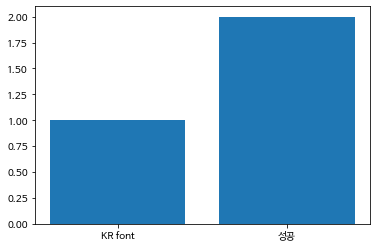

In [ ]:
# Download libraries
base_dir=setup()

# Import libraries

# For web crawling
from bs4 import BeautifulSoup
import requests as rq
import re

# For naming
import datetime

# For word cloud generating
import numpy as np
import random
from PIL import Image
from wordcloud import WordCloud, STOPWORDS
from palettable.colorbrewer.qualitative import Dark2_8

# For kr analysis
import konlpy
import nltk

# For set delay
import time

# For emoji delete
import emoji

# For draw legend
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm

In [ ]:
'''
# Example use for dcinside
Keyword_analyzer(site='dc',
                 board_id='hypergryph',
                 user_agent="PUT YOUR USER AGENT",
                 crawl_pages=[[7,49],[49,107],[107,144]],
                 crawl_title=True, 
                 crawl_article=False,
                 show_ranking=True,
                 show_rank=10,
                 is_m_gallery=True,
                 cloud_mask="PUT YOUR USER IMAGE",
                 custom_word_corpus="dc_ark_user_dic_v20210107.txt",
                 dc_official_announce=2,
                 base_dir=base_dir)'''

In [ ]:
'''
# Example use for recover wordcloud and ranking with crawled txt files
recover_wordcloud(site='dc',
                  board_id='hypergryph',
                  time_code='210107 19-52-18',
                  crawl_pages=[[7,49],[49,107],[107,144]],
                  cloud_mask="PUT YOUR USER IMAGE",
                  crawl_title=True, 
                  crawl_article=False,
                  show_ranking=True,
                  show_rank=10, 
                  custom_word_corpus="dc_ark_user_dic_v20210107.txt",
                  base_dir=base_dir)'''

In [ ]:
'''
# Example use for Ruliweb
Keyword_analyzer(site='ruliweb',
                 board_id='300143',
                 user_agent="PUT YOUR USER AGENT",
                 crawl_pages=[[1,2]],
                 crawl_title=True, 
                 crawl_article=True,
                 show_ranking=True,
                 show_rank=10,
                 cloud_mask="PUT YOUR USER IMAGE",
                 custom_word_corpus="ruliweb_user_dic_v20201109.txt",
                 dc_official_announce=2,
                 base_dir=base_dir)'''

In [ ]:
'''# Example use for Arcalive
Keyword_analyzer(site='arca',
                 board_id='lastorigin',
                 user_agent="PUT YOUR USER AGENT",
                 crawl_pages=[[2,3]],
                 crawl_title=True, 
                 crawl_article=True,
                 show_ranking=True,
                 show_rank=10,
                 is_m_gallery=True,
                 cloud_mask="PUT YOUR USER IMAGE",
                 base_dir=base_dir,
                 request_delay=2)                '''

In [ ]:
'''
# Example use for recover wordcloud and ranking with crawled txt files
recover_wordcloud(site='ruliweb',
                  board_id='300143',
                  time_code='201109 19-09-57',
                  crawl_pages=[[1,2]],
                  cloud_mask="PUT YOUR USER IMAGE",
                  crawl_title=True, 
                  crawl_article=False,
                  show_ranking=True,
                  show_rank=5, 
                  custom_word_corpus="ruliweb_user_dic_v20201109.txt",
                  base_dir=base_dir)'''

In [ ]:
'''
# Example use for Keyword_relation_analyzer()
Keyword_relation_analyzer_v1dx(site='dc',
                          board_id='hypergryph',
                          user_agent="PUT YOUR USER AGENT",
                          crawl_pages=[[1,213]],
                          crawl_title=True, 
                          crawl_article=True,
                          show_ranking=True,
                          show_rank=10,
                          is_m_gallery=True,
                          cloud_mask="PUT YOUR USER IMAGE",
                          custom_word_corpus="dc_ark_user_dic_v20210122.txt",
                          dc_official_announce=1,
                          base_dir=base_dir,
                          keywords=["상시","18점","19점","20점","21점","22점","23점","24점","25점","26점","27점"])'''

In [ ]:
'''
# Example use for recover wordcloud and ranking with crawled txt files
recover_known_Keyword_wordcloud(site='dc',
                  board_id='hypergryph',
                  time_code='210126 02-37-09',
                  crawl_pages=[[1,213]],
                  cloud_mask="PUT YOUR USER IMAGE",
                  crawl_title=True, 
                  crawl_article=True,
                  show_ranking=True,
                  show_rank=15, 
                  custom_word_corpus="dc_ark_user_dic_v20210122.txt",
                  base_dir=base_dir,
                  known_keyword_list="ark_op_name_list 20210103.txt")'''

In [ ]:
'''
# Example use for dcinside (v 1.x version)
Keyword_analyzer_v1dx(site='dc',
                 board_id='mibj',
                 user_agent="PUT YOUR USER AGENT",
                 crawl_pages=[[12,123],[123,284],[284,393]],
                 crawl_title=True, 
                 crawl_article=False,
                 show_ranking=True,
                 show_rank=10,
                 is_m_gallery=True,
                 cloud_mask="PUT YOUR USER IMAGE",
                 custom_word_corpus="dc_ark_user_dic_v20210122.txt",
                 dc_official_announce=1,
                 base_dir=base_dir)'''